# Run DFN and low Neg porosity of 0.1, use two type of electrolyte: Nyman2008 original (apolynomial form) and Nyman2008 exponential (my own extrapolation, based on the fact that at high c(Li+) will ). During discharge, the large c(Li+) will fail all polynomial forms of electrolyte property (diffusivity and conductivity and give wrong results). If we take the form of exponential, that can ensure low diffusivity and conductivity, but that seems to cause some numerical problems.

In [29]:
# import modules
import pybamm
import numpy as np;import matplotlib.pyplot as plt;
from pybamm import constants,exp,tanh,sqrt;

In [30]:
from pybamm import exp,sqrt
def electrolyte_diffusivity_Nyman2008Exp(c_e, T):
    D_c_e = (
        6 * exp( -1 *(c_e/1000)) 
        * exp(-5/298.15) 
        * exp(-95/298.15*(c_e/1000)) * 1e-10 
    )
    return D_c_e

def electrolyte_conductivity_Nyman2008Exp(c_e, T):
    sigma_e = (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) 
    )
    return sigma_e
print(electrolyte_diffusivity_Nyman2008Exp(10,298.15))
print(electrolyte_conductivity_Nyman2008Exp(10,298.15))


5.822927088266968e-10
0.03803688841420761


In [31]:
# set-up and run model
V_max = 4.2;        V_min = 2.5;
total_cycle = 1; save_at_cycles= 1
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V (1 minutes period)" , )] * total_cycle ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 20 minutes (10 seconds period)" , )] * total_cycle ) 

Sim = [];Sol=[]; 

Para_0 = pybamm.ParameterValues("Chen2020")

Para_0['Negative electrode porosity'] =  0.1
var = pybamm.standard_spatial_vars  
mesh_thick = 30; mesh_par=30;
var_pts = {
    var.x_n: int(mesh_thick),  
    var.x_s: int(20),  
    var.x_p: int(mesh_thick),  
    var.r_n: int(mesh_par),  
    var.r_p: int(mesh_par),  }  


In [32]:
pybamm.settings.tolerances['D_e__c_e'] = 10

In [33]:
# Run the first model, with Nyman2008 polynimial form
model = pybamm.lithium_ion.DFN()
c_e = model.variables["Electrolyte concentration [mol.m-3]"]
T = model.variables["Cell temperature [K]"]
model.variables["Electrolyte conductivity [S.m-1]"] =(
    Para_0['Electrolyte conductivity [S.m-1]'](c_e, T))
model.variables["Electrolyte diffusivity [m2.s-1]"] =(
    Para_0['Electrolyte diffusivity [m2.s-1]'](c_e, T))

sim = pybamm.Simulation(
    model, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),
    var_pts=var_pts,)  
try:
    sol = sim.solve(save_at_cycles=save_at_cycles,);
    print(sol.cycles[-1].steps[-1]);  # a way to check whether the solution is finalized 
except:
    print('Fail for electrolyte: Poly')
else:
    Sol.append(sol)   
    print('Succeed for electrolyte: Poly')


Succeed for electrolyte: Poly


In [34]:
# Run the first model, with Nyman2008 exponeitial form
model_2 = pybamm.lithium_ion.DFN()
Para_0.update({
    'Electrolyte conductivity [S.m-1]': 
    electrolyte_conductivity_Nyman2008Exp})
Para_0.update({
    'Electrolyte diffusivity [m2.s-1]': 
    electrolyte_diffusivity_Nyman2008Exp})
c_e = model_2.variables["Electrolyte concentration [mol.m-3]"]
T = model_2.variables["Cell temperature [K]"]
model_2.variables["Electrolyte conductivity [S.m-1]"] =(
    Para_0['Electrolyte conductivity [S.m-1]'](c_e, T))
model_2.variables["Electrolyte diffusivity [m2.s-1]"] =(
    Para_0['Electrolyte diffusivity [m2.s-1]'](c_e, T))

sim_2 = pybamm.Simulation(
    model_2, experiment = Experiment_Long,
    parameter_values = Para_0,
    solver = pybamm.CasadiSolver(),
    var_pts=var_pts,)  
try:
    sol_2 = sim_2.solve(save_at_cycles=save_at_cycles,);
    print(sol_2.cycles[-1].steps[-1]);  # a way to check whether the solution is finalized 
except:
    print('Fail for electrolyte: Exp')
else:
    Sol.append(sol_2)   
    print('Succeed for electrolyte: Exp')


Succeed for electrolyte: Exp


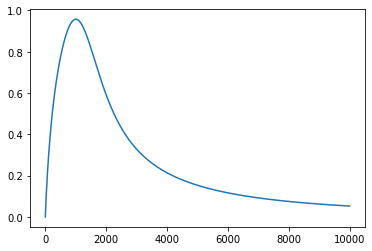

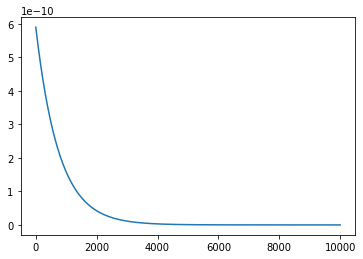

<AxesSubplot:>

In [35]:
# plot the exponential diffusivity and conductivity 
c_e_plot = pybamm.linspace(0, 1e4, 1000)
signam_exp = pybamm.Array(Para_0.evaluate(electrolyte_conductivity_Nyman2008Exp(c_e_plot,298.15)))
diff_exp   = pybamm.Array(Para_0.evaluate(electrolyte_diffusivity_Nyman2008Exp (c_e_plot,298.15)))

pybamm.plot(c_e_plot, signam_exp)
pybamm.plot(c_e_plot, diff_exp)

In [36]:
print(len(sol_2["Electrolyte conductivity [S.m-1]"].entries[0,:] ))

26


In [40]:
print(Sol[1]["Electrolyte concentration [mol.m-3]"].entries[:,23] )
print(Sol[1]["Electrolyte conductivity [S.m-1]"].entries[:,23] )

[ 1.12954374e+04  1.13044155e+04  1.13225043e+04  1.13498424e+04
  1.13866352e+04  1.14331615e+04  1.14897802e+04  1.15569381e+04
  1.16351790e+04  1.17251568e+04  1.18276502e+04  1.19435826e+04
  1.20740459e+04  1.22203314e+04  1.23839676e+04  1.25667702e+04
  1.27709040e+04  1.29989650e+04  1.32540870e+04  1.35400840e+04
  1.38616405e+04  1.42245735e+04  1.46361945e+04  1.51058209e+04
  1.56455039e+04  1.62710594e+04  1.70033901e+04  1.78683314e+04
  1.88399371e+04  1.89471863e+03  1.89087562e+03  1.88317151e+03
  1.87173202e+03  1.85677775e+03  1.83862111e+03  1.81764404e+03
  1.79425981e+03  1.76887460e+03  1.74186142e+03  1.71354788e+03
  1.68421367e+03  1.65409316e+03  1.62338037e+03  1.59223458e+03
  1.56078579e+03  1.52913972e+03  1.49738209e+03  1.46558236e+03
  1.43379673e+03  1.40207073e+03  1.37044119e+03  1.33893796e+03
  1.30758518e+03  1.27640236e+03  1.24540522e+03  1.21460634e+03
  1.18401572e+03  1.15364120e+03  1.12348878e+03  1.09356294e+03
  1.06386689e+03  1.03440

In [39]:
label = ['Nyman - Poly', 'Nyman - Exp', ]
output_variables3 = [
    "Terminal voltage [V]",   
    "Electrolyte potential [V]",
    "Electrolyte concentration [mol.m-3]",
    "Electrolyte flux [mol.m-2.s-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Electrolyte conductivity [S.m-1]"
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='minutes',n_rows=2,
    figsize = (12,8)) #     spatial_unit='mm',
quick_plot.dynamic_plot();


interactive(children=(FloatSlider(value=0.0, description='t', max=58.89045942714018, step=0.5889045942714017),…